In [2]:
%matplotlib inline
import math
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Using TensorFlow backend.


In [9]:
hpi = pd.DataFrame(pd.read_csv('../Data/hpi_final.csv'))

In [10]:
hpi = hpi[['county', 'year', 'hpi','one_year', 'two_years', 'three_years',
       'four_years', 'five_years'
          ]]
hpi.rename(columns={'county': 'county_code'}, inplace=True)

In [11]:
hpi.head()

,county_code,year,hpi,one_year,two_years,three_years,four_years,five_years
0,10001,1986,100.000000,0.057325,0.123340,0.194460,0.217233,0.204775
1,10001,1987,105.732500,0.062436,0.129700,0.151239,0.139456,0.065417
2,10001,1988,112.334000,0.063311,0.083584,0.072494,0.002806,0.001800
3,10001,1989,119.446000,0.019066,0.008636,-0.056902,-0.057848,-0.069229
4,10001,1990,121.723333,-0.010235,-0.074547,-0.075475,-0.086643,-0.073668


In [12]:
hpi2 = hpi.set_index(['county_code', 'year'])
hpi2.head()

hpi  one_year  two_years  three_years  four_years  \
county_code year                                                             
10001       1986  100.000000  0.057325   0.123340     0.194460    0.217233   
            1987  105.732500  0.062436   0.129700     0.151239    0.139456   
            1988  112.334000  0.063311   0.083584     0.072494    0.002806   
            1989  119.446000  0.019066   0.008636    -0.056902   -0.057848   
            1990  121.723333 -0.010235  -0.074547    -0.075475   -0.086643   

                  five_years  
county_code year              
10001       1986    0.204775  
            1987    0.065417  
            1988    0.001800  
            1989   -0.069229  
            1990   -0.073668

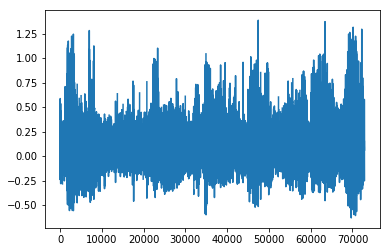

In [13]:
dataset = pd.read_csv('../Data/hpi_final.csv', usecols=[7], engine='python')
plt.plot(dataset)
plt.show()

In [14]:
hpi3 = hpi2['five_years']
hpi3.head()

county_code  year
10001        1986    0.204775
             1987    0.065417
             1988    0.001800
             1989   -0.069229
             1990   -0.073668
Name: five_years, dtype: float64

In [15]:
hpi3 = hpi3.replace([np.inf, -np.inf], np.nan)
hpi3 = hpi3.dropna()

In [16]:
hpi_data_5y = hpi3.values
hpi_data_5y = hpi_data_5y.astype('float32')
hpi_data_5y

array([ 0.204775  ,  0.06541726,  0.00180043, ..., -0.02048359,
        0.05480948,  0.14936665], dtype=float32)

In [17]:
hpi_data_5y1 = hpi_data_5y.reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
hpi_data_5y1 = min_max_scaler.fit_transform(hpi_data_5y1)
print(len(hpi_data_5y1))

59864


In [18]:
# split into train and test sets
train_size = int(len(hpi_data_5y1) * 0.67)
test_size = len(hpi_data_5y1) - train_size 
train, test = hpi_data_5y1[0:train_size,:], hpi_data_5y1[train_size:len(hpi_data_5y1),:]
print(len(train), len(test))
print(train_size)

40108 19756
40108


In [19]:
# convert an array of values into a dataset matrix
def hpi_dataset(hpi_data2, tminus=1):
    X_data, Y_data = [], []
    for i in range(len(hpi_data2)-tminus-1):
        a = hpi_data2[i:(i+tminus), 0]
        X_data.append(a)
        Y_data.append(hpi_data2[i + tminus, 0])
    return np.array(X_data), np.array(Y_data)

In [20]:
tminus = 6
X_train, Y_train = hpi_dataset(train, tminus)
X_test, Y_test = hpi_dataset(test, tminus)

In [21]:
X_train.shape

(40101, 6)

In [22]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [23]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(2, input_shape=(1, tminus)))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [24]:
%time
model.summary()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [29]:
%time
history = model.fit(X_train, Y_train, epochs=10, batch_size=1, verbose=2)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.82 µs
Epoch 1/10
 - 78s - loss: 0.0021 - mean_absolute_error: 0.0320
Epoch 2/10
 - 77s - loss: 0.0020 - mean_absolute_error: 0.0319
Epoch 3/10
 - 75s - loss: 0.0020 - mean_absolute_error: 0.0318
Epoch 4/10
 - 71s - loss: 0.0020 - mean_absolute_error: 0.0317
Epoch 5/10
 - 70s - loss: 0.0020 - mean_absolute_error: 0.0317
Epoch 6/10
 - 71s - loss: 0.0020 - mean_absolute_error: 0.0316
Epoch 7/10
 - 73s - loss: 0.0020 - mean_absolute_error: 0.0315
Epoch 8/10
 - 75s - loss: 0.0020 - mean_absolute_error: 0.0315
Epoch 9/10
 - 71s - loss: 0.0020 - mean_absolute_error: 0.0314
Epoch 10/10
 - 76s - loss: 0.0020 - mean_absolute_error: 0.0315


In [31]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict1 = min_max_scaler.inverse_transform(trainPredict)
trainY1 = min_max_scaler.inverse_transform([Y_train])
testPredict1 = min_max_scaler.inverse_transform(testPredict)
testY1 = min_max_scaler.inverse_transform([Y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY1[0], trainPredict1[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY1[0], testPredict1[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.10 RMSE
Test Score: 0.10 RMSE


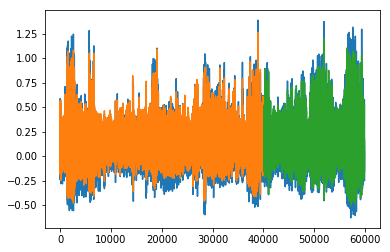

In [34]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(hpi_data_5y1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[tminus:len(trainPredict1)+tminus, :] = trainPredict1
# shift test predictions for plotting
testPredictPlot = np.empty_like(hpi_data_5y1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict1)+(tminus*2)+1:len(hpi_data_5y1)-1, :] = testPredict1
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(hpi_data_5y1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [35]:
model.save("RNN_5y.h5")